In [1]:
import xml.etree.ElementTree as et
import matplotlib.pyplot as plt
import datetime as dt
import seaborn as sns
import pandas as pd
import numpy as np

tree = et.parse('/content/export.xml')
root = tree.getroot()
record = [x.attrib for x in root.iter('Record')]
df = pd.DataFrame(record)

print(df.info())
print(df['type'].unique())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 197563 entries, 0 to 197562
Data columns (total 9 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   type           197563 non-null  object
 1   sourceName     197563 non-null  object
 2   sourceVersion  196828 non-null  object
 3   device         194456 non-null  object
 4   unit           193721 non-null  object
 5   creationDate   197563 non-null  object
 6   startDate      197563 non-null  object
 7   endDate        197563 non-null  object
 8   value          197563 non-null  object
dtypes: object(9)
memory usage: 13.6+ MB
None
['HKQuantityTypeIdentifierStepCount'
 'HKQuantityTypeIdentifierDistanceWalkingRunning'
 'HKQuantityTypeIdentifierBasalEnergyBurned'
 'HKQuantityTypeIdentifierActiveEnergyBurned'
 'HKQuantityTypeIdentifierFlightsClimbed'
 'HKQuantityTypeIdentifierHeadphoneAudioExposure'
 'HKQuantityTypeIdentifierWalkingDoubleSupportPercentage'
 'HKQuantityTypeIdentifierWalkin

In [2]:
# clean data: turn 'date' type into datetime. Drop time for one of three 'date' related var
for col in ['creationDate', 'startDate', 'endDate']:
    df[col] = pd.to_datetime(df[col])

df['date'] = df['endDate'].dt.date

In [3]:
# clean data: turn 'value' into numeric and fill NaN in with 1.0 for easier aggregation
df['value'] = pd.to_numeric(df['value'], errors='coerce')
df['value'] = df['value'].fillna(1.0)

In [4]:
# clean data: delete strings that carry duplicate info in 'type'
df['type'] = df['type'].str.replace('HKQuantityTypeIdentifier', '')
df['type'] = df['type'].str.replace('HKCategoryTypeIdentifier', '')

In [5]:
# create a new df with values aggregated by date (not hours)
df1 = df.groupby(['date', 'type']).agg({'value': 'sum'}).reset_index()
df1['date'] = pd.to_datetime(df1['date'])

In [6]:
# clean data: in new df, create new variables for year, month, and day of the week
# in dt.dayofweek, 0 = Mon, 6 = Sun
df1['year'] = df1['date'].dt.strftime('%Y')
df1['month'] = df1['date'].dt.strftime('%m')
df1['dayOfWeek'] = df1['date'].dt.dayofweek

df1_step = df1[(df1['type']=='StepCount') & (df1['date'] >= '2020-01-01')].reset_index()
df1_step.sort_values(by='date', inplace=True)

In [7]:
# when was the max steps each year?
df1 = df1.sort_values(by='value')
print(df1[df1['date'].dt.strftime('%Y').str.contains('2024')].tail(3))
print(df1[df1['date'].dt.strftime('%Y').str.contains('2023')].tail(3))
print(df1[df1['date'].dt.strftime('%Y').str.contains('2022')].tail(3))
print(df1.tail(3))

            date       type    value  year month  dayOfWeek
12259 2024-01-01  StepCount  14803.0  2024    01          0
13083 2024-03-21  StepCount  18072.0  2024    03          3
13160 2024-03-28  StepCount  19276.0  2024    03          3
            date       type    value  year month  dayOfWeek
9646  2023-04-17  StepCount  19854.0  2023    04          0
10626 2023-07-22  StepCount  20066.0  2023    07          5
9210  2023-02-24  StepCount  24209.0  2023    02          4
           date       type    value  year month  dayOfWeek
7205 2022-06-05  StepCount  16175.0  2022    06          6
6237 2022-02-06  StepCount  16346.0  2022    02          6
8682 2022-12-14  StepCount  25563.0  2022    12          2
           date       type    value  year month  dayOfWeek
1171 2018-11-29  StepCount  44365.0  2018    11          3
1528 2019-03-25  StepCount  45493.0  2019    03          0
1708 2019-05-24  StepCount  50506.0  2019    05          4


In [8]:
# which day of the week do I tend to walk more?
pivot = df1_step.pivot_table(index='dayOfWeek', columns='year', values='value', aggfunc='median')
pivot = pivot.reset_index()
print(pivot)


year  dayOfWeek    2020    2021    2022    2023    2024
0             0  1847.5  3177.0  5308.0  6349.0  4931.0
1             1   499.5  2414.0   787.0  4042.5  4132.0
2             2   285.0  1828.0  2486.5  2083.0  4938.0
3             3   540.0  3462.0  3370.5  2725.0  8515.0
4             4  1566.5   870.5  1962.0  2562.5  3914.0
5             5  2115.5  4087.0  4580.0  5182.0  7944.5
6             6  1414.5  5417.0  7564.0  9026.5  2735.5


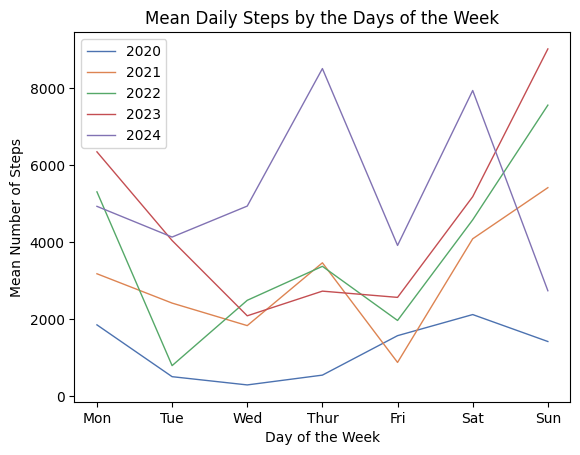

In [9]:
# visualize 'daily stesp by the day of the week'

fig, ax = plt.subplots()

colors = list(sns.color_palette('deep'))
years = list(df1_step['year'].unique())

for i, year in enumerate(years):
    ax.plot(pivot['dayOfWeek'], pivot[year], color=colors[i], linewidth=1, label=year)

plt.title('Mean Daily Steps by the Days of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Mean Number of Steps')
plt.xticks(pivot['dayOfWeek'], ['Mon', 'Tue', 'Wed','Thur', 'Fri', 'Sat', 'Sun'])
plt.legend()
plt.show()

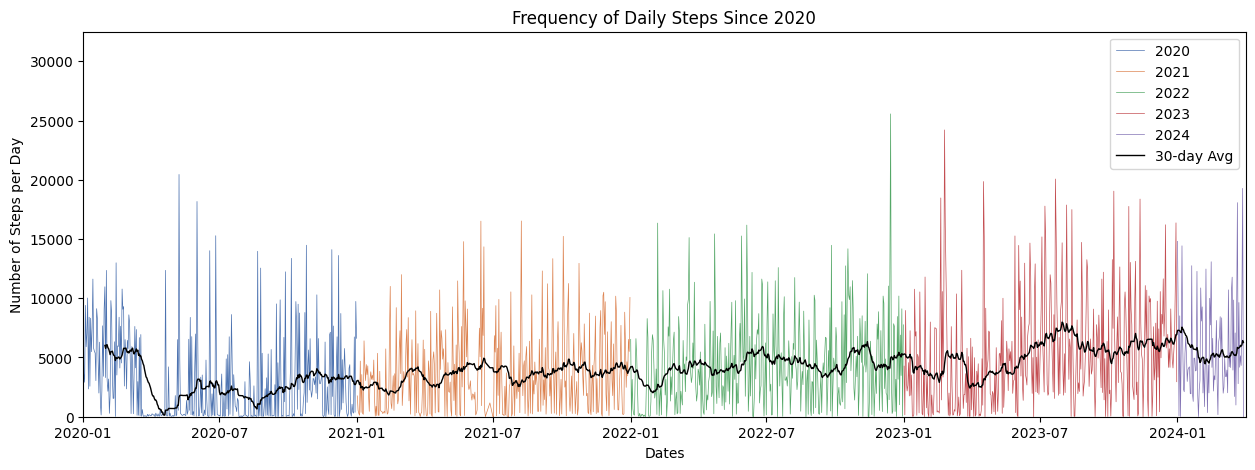

In [11]:
# visualize daily steps from every day since 2020, color code years

fig, ax = plt.subplots(figsize=(15, 5))

def plot_series(series, name, i=0):
  xs = series['date']
  ys = series['value']
  palette = list(sns.color_palette('deep'))
  plt.plot(xs, ys, label=name, linewidth=0.5, color=palette[i])
  # in case the number of color palette runs out, I can use: color=palette[i % len(palette)]

for i, (name, series) in enumerate(df1_step.groupby('year')):
  plot_series(series, name, i)

rolling_avg = df1_step['value'].rolling(window=30).mean()
plt.plot(df1_step['date'], rolling_avg, linewidth=1, color='black', label = '30-day Avg')

plt.title('Frequency of Daily Steps Since 2020')
plt.xlabel('Dates')
plt.ylabel('Number of Steps per Day')
plt.xlim(pd.Timestamp('2020-01'), pd.Timestamp('2024-04'))
plt.ylim(0, 32500)
plt.legend()
plt.show()

Text(0.5, 0, 'Number of Steps per Day')

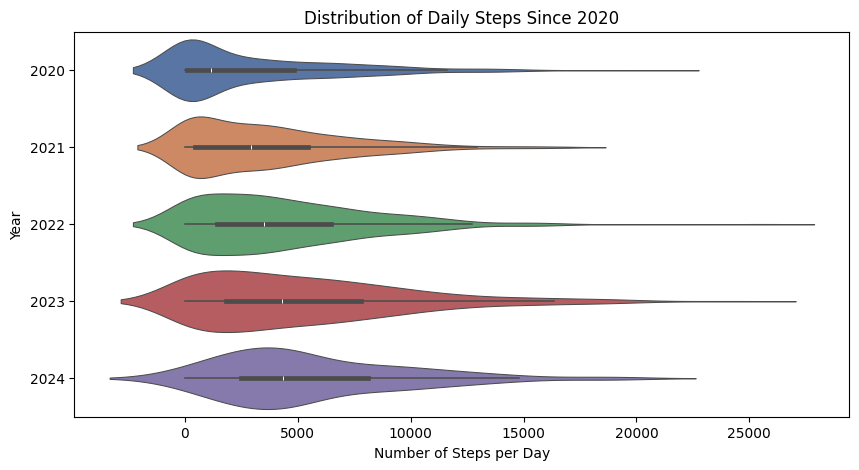

In [12]:
# visual side by side comparison of the distributino of daily steps per year

plt.figure(figsize=(10, 5))
sns.violinplot(df1_step, x='value', y='year', inner='box', linewidth=0.75, hue='year', palette='deep')
plt.title('Distribution of Daily Steps Since 2020')
plt.ylabel('Year')
plt.xlabel('Number of Steps per Day')